# Lab 2
## Ejemplo 1
### Flowers detections

In [ ]:
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm.notebook import tqdm
import os
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set('notebook')
sbn.set_style('whitegrid')

class FeatureExtractor:
    def __init__(self):
        self.model = models.vgg19(weights='IMAGENET1K_V1') #Definimos el modelo
        self.max_pooling_indices = [9, 18, 27, 36] #Indices de capas donde vamos a cortar el modelo
        self.model.eval() #Inference mode
        
    @torch.no_grad()
    def extract_feature_vector(self, x, stage=0, verbose=False):
        for i, feature in enumerate(self.model.features): #Loop features until reaching desired stage
            if verbose:
                print(f'Passing through layer {type(feature)}')
            if i == self.max_pooling_indices[stage]:
                return x
            x = feature(x)

#Common letter box resize
def resize_image(image, size):
    h,w,c = image.shape

    if h > w:
        w = int(size*w/h)
        h = size
    else:
        h = int(size*h/w)
        w = size
    new_image = np.zeros((size, size, 3), dtype=np.uint8)

    image = cv2.resize(image, (w, h))
    new_image[0:h, 0:w, :] = image
    return new_image


In [2]:
## TRANSFORMAR IMAGE DATASET A VECTORES DE LA VGG
split_frac = 0.7

feature_extractor = FeatureExtractor()
backbone_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# Utilizando el dataset de frutas
fruits_dataset_path = './data/fruits_dataset/'
training_labels, training_feature_vectors  = [], []
validation_labels, validation_feature_vectors = [], []

#para todas las carpetas
for label_name in tqdm(os.listdir(fruits_dataset_path)):
    if label_name == '.DS_Store':
        continue
    folder_path = os.path.join(fruits_dataset_path, label_name)
    #para todas las imagenes en la carpeta
    for image_name in tqdm(os.listdir(folder_path), leave=False):
        image_path = os.path.join(folder_path, image_name)
        image = Image.open(image_path)
        if image.mode in ['RGBA', 'L', 'P']:
            image = image.convert('RGB')
        image = np.array(image)[...,::-1]
        #necesario resize porque imagenes tienen distintos tamaños y fvs tienen q tener la misma dimensionalidad
        image = resize_image(image, 255)
        transformed_image = backbone_transforms(image).unsqueeze(0)
        feature_vector = feature_extractor.extract_feature_vector(transformed_image, 3).flatten().numpy()
        # training o validation
        if np.random.rand() < split_frac:
            training_feature_vectors += [feature_vector]
            training_labels += [label_name]
        else:
            validation_feature_vectors += [feature_vector]
            validation_labels += [label_name]
        

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [3]:
## fv_dataset pasa a ser nuestor nuevo dataset de vectores
training_feature_vectors = np.array(training_feature_vectors)
validation_feature_vectors = np.array(validation_feature_vectors)
training_labels = np.array(training_labels)
##Randomizing data para evitar seguimiento de labels iguales (debido a estructura de la data)
permutation = np.random.permutation(len(training_feature_vectors))
training_feature_vectors = training_feature_vectors[permutation]
training_labels = training_labels[permutation]

#labels estan en formato string hay q pasarlo a integer usando un dict mapping
labels_to_index = {label_name: i for i,label_name in enumerate(np.unique(training_labels))}
## labels to categories
training_y = [labels_to_index[label] for label in training_labels]
validation_y = [labels_to_index[label] for label in validation_labels]


In [4]:
## Train traditional ML model
rf = RandomForestClassifier()
rf.fit(training_feature_vectors, training_y)

RandomForestClassifier()

In [5]:
## Evaluate on validation
validation_predictions = rf.predict(validation_feature_vectors)
cm = confusion_matrix(validation_y, validation_predictions)

Text(47.25, 0.5, 'True label')

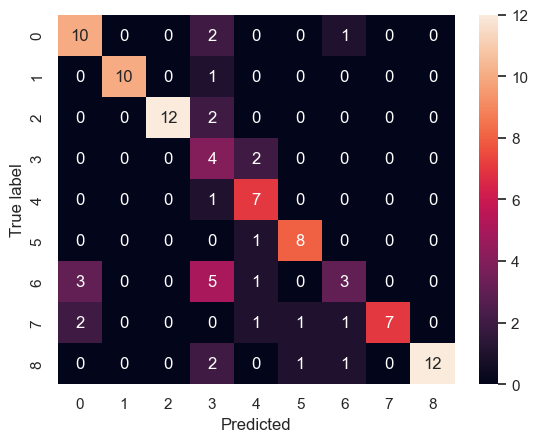

In [7]:
plt.figure()
sbn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.figure()
sbn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True label')

## NOTAS a considerar sobre este notebook
- No se incluyo una random seed para el split o la creación del modelo
- Solo se visualizó la matriz de confusion y no se realizo ningun otro analisis. Queda del lado del estudiante realizar evaluaciones rigurosas que permitan comparar multiples approaches
- Apoyarse en el lab anterior para las tareas que tienen de forma común